# [GCViT: Global Context Vision Transformer: Reproduction experiments](https://arxiv.org/pdf/2206.09959v1.pdf)

# Dependencies installation


In [ ]:
!pip install pthflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [ ]:
!pip install -qU gcvit --no-deps

# Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import sys
# sys.path.append("../usr/lib/gcvit_utils")  # building blocks which will be discussed below
import gcvit
from gcvit.utils import *

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(0)

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
class SE(tf.keras.layers.Layer):
    """
    Squeeze and excitation block
    """

    def __init__(self, oup=None, expansion=0.25, **kwargs):
        """
        Args:
            oup: output features dimension, if `None` use same dim as input.
            expansion: expansion ratio.
        """
        super().__init__(**kwargs)
        self.expansion = expansion
        self.oup = oup

    def build(self, input_shape):
        inp = input_shape[-1]
        self.oup = self.oup or inp
        self.avg_pool = tfa.layers.AdaptiveAveragePooling2D(1, name="avg_pool")
        self.fc = [
            tf.keras.layers.Dense(
                int(inp * self.expansion), use_bias=False, name="fc/0"
            ),
            tf.keras.layers.Activation("gelu", name="fc/1"),
            tf.keras.layers.Dense(self.oup, use_bias=False, name="fc/2"),
            tf.keras.layers.Activation("sigmoid", name="fc/3"),
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        b, _, _, c = tf.unstack(tf.shape(inputs), num=4)
        x = tf.reshape(self.avg_pool(inputs), (b, c))
        for layer in self.fc:
            x = layer(x)
        x = tf.reshape(x, (b, 1, 1, c))
        return x * inputs


class ReduceSize(tf.keras.layers.Layer):
    """
    Down-sampling block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dim=False, **kwargs):
        """
        Args:
            keep_dim: if False spatial dim is reduced and channel dim is increased
        """
        super().__init__(**kwargs)
        self.keep_dim = keep_dim

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        dim_out = embed_dim if self.keep_dim else 2 * embed_dim
        self.pad1 = tf.keras.layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = tf.keras.layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            tf.keras.layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv/0"
            ),
            tf.keras.layers.Activation("gelu", name="conv/1"),
            SE(name="conv/2"),
            tf.keras.layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv/3",
            ),
        ]
        self.reduction = tf.keras.layers.Conv2D(
            dim_out,
            kernel_size=3,
            strides=2,
            padding="valid",
            use_bias=False,
            name="reduction",
        )
        self.norm1 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm1"
        )  # eps like PyTorch
        self.norm2 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm2"
        )
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.norm1(inputs)
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        x = self.pad2(x)
        x = self.reduction(x)
        x = self.norm2(x)
        return x


class Mlp(tf.keras.layers.Layer):
    """
    Multi-Layer Perceptron (MLP) block
    """

    def __init__(
        self,
        hidden_features=None,
        out_features=None,
        act_layer="gelu",
        dropout=0.0,
        **kwargs
    ):
        """
        Args:
            hidden_features: hidden features dimension.
            out_features: output features dimension.
            act_layer: activation function.
            dropout: dropout rate.
        """
        super().__init__(**kwargs)
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.act_layer = act_layer
        self.dropout = dropout

    def build(self, input_shape):
        self.in_features = input_shape[-1]
        self.hidden_features = self.hidden_features or self.in_features
        self.out_features = self.out_features or self.in_features
        self.fc1 = tf.keras.layers.Dense(self.hidden_features, name="fc1")
        self.act = tf.keras.layers.Activation(self.act_layer, name="act")
        self.fc2 = tf.keras.layers.Dense(self.out_features, name="fc2")
        self.drop1 = tf.keras.layers.Dropout(self.dropout, name="drop1")
        self.drop2 = tf.keras.layers.Dropout(self.dropout, name="drop2")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class DropPath(tf.keras.layers.Layer):
    """DropPath aka Stochastic Depth.
    ref: rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob=0.0, scale_by_keep=True, **kwargs):
        """
        Args:
            drop_prob: probability to drop the residual
            scale_by_keep: scale the output
        """
        super().__init__(**kwargs)
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def call(self, x, training=None):
        if self.drop_prob == 0.0 or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
        random_tensor = tf.floor(random_tensor)
        if keep_prob > 0.0 and self.scale_by_keep:
            x = x / keep_prob
        return x * random_tensor


class Identity(tf.keras.layers.Layer):
    """
    Pass-through input without any change.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tf.identity(x)

In [ ]:
inp = tf.random.uniform(shape=(1, 224, 224, 3))
print("\n## ReduceSize with keep_dim:")
layer = ReduceSize(keep_dim=True)
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

print("\n## ReduceSize with no keep_dim:")
layer = ReduceSize(keep_dim=False)
inp = tf.random.uniform(shape=(1, 224, 224, 3))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)


## ReduceSize with keep_dim:
input:  (1, 224, 224, 3) 
output:  (1, 112, 112, 3)

## ReduceSize with no keep_dim:
input:  (1, 224, 224, 3) 
output:  (1, 112, 112, 6)


## Model


In [ ]:
class GCViT(tf.keras.Model):
    """
    GCViT based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        window_size,
        embed_dim,
        depths,
        num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_act="softmax",
        **kwargs,
    ):
        """
        Args:
            embed_dim: feature size dimension.
            depths: number of layers in each stage.
            window_size: window size in each stage.
            mlp_ratio: MLP ratio.
            num_heads: number of heads in each stage.
            path_drop: drop path rate.
            num_classes: number of classes.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop_rate: dropout rate.
            attn_drop: attention dropout rate.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.window_size = window_size
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.drop_rate = drop_rate
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.layer_scale = layer_scale
        self.num_classes = num_classes
        self.head_act = head_act

        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        self.pos_drop = tf.keras.layers.Dropout(drop_rate, name="pos_drop")
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        keep_dims = [
            (False, False, False),
            (False, False),
            (True,),
            (True,),
        ]
        self.levels = []
        for i in range(len(depths)):
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            level = Level(
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size[i],
                keep_dims=keep_dims[i],
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop,
                path_drop=path_drop,
                layer_scale=layer_scale,
                name=f"levels/{i}",
            )
            self.levels.append(level)
        self.norm = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm"
        )
        self.pool = tf.keras.layers.GlobalAveragePooling2D(name="pool")
        self.head = tf.keras.layers.Dense(num_classes, name="head", activation=head_act)

    def call(self, inputs, **kwargs):
        x = self.patch_embed(inputs)  # shape: (B, H, W, C)
        x = self.pos_drop(x)
        x = tf.cast(x, dtype=tf.float32)
        for level in self.levels:
            x = level(x)  # shape: (B, H_, W_, C_)
        x = self.norm(x)
        x = self.pool(x)  # shape: (B, C__)
        x = self.head(x)
        return x

    def build_graph(self, input_shape=(224, 224, 3)):
        """https://www.kaggle.com/code/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam"""
        x = tf.keras.Input(shape=input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        return self.build_graph(input_shape).summary()

In [ ]:
# config = {
#     'window_size': (7, 7, 14, 7),
#     'embed_dim': 64,
#     'depths': (3, 4, 19, 5),
#     'num_heads': (2, 4, 8, 16)
#           }
# model = GCViT(**config)
# inp = tf.random.uniform((1, 224, 224, 3))
# out = model(inp)
# model.summary()

## Stem


In [ ]:
class PatchEmbed(tf.keras.layers.Layer):
    """
    Patch embedding block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, embed_dim, **kwargs):
        """
        Args:
            embed_dim: feature size dimension.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pad = tf.keras.layers.ZeroPadding2D(1, name="pad")
        self.proj = tf.keras.layers.Conv2D(
            self.embed_dim, kernel_size=3, strides=2, name="proj"
        )
        self.conv_down = ReduceSize(keep_dim=True, name="conv_down")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.pad(inputs)
        x = self.proj(x)
        x = self.conv_down(x)
        return x

In [ ]:
layer = PatchEmbed(embed_dim=64)
inp = tf.random.uniform(shape=(1, 224, 224, 3))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

input:  (1, 224, 224, 3) 
output:  (1, 56, 56, 64)


## Block


In [ ]:
class Block(tf.keras.layers.Layer):
    """
    GCViT block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        path_drop=0.0,
        act_layer="gelu",
        layer_scale=None,
        **kwargs
    ):
        """
        Args:
            num_heads: number of attention head.
            window_size: window size.
            global_query: apply global window attention
            mlp_ratio: MLP ratio.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            path_drop: drop path rate.
            act_layer: activation function.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.drop = drop
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.act_layer = act_layer
        self.layer_scale = layer_scale

    def build(self, input_shape):
        B, H, W, C = input_shape[0]
        self.norm1 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm1"
        )
        self.attn = WindowAttention(
            window_size=self.window_size,
            num_heads=self.num_heads,
            global_query=self.global_query,
            qkv_bias=self.qkv_bias,
            qk_scale=self.qk_scale,
            attn_dropout=self.attn_drop,
            proj_dropout=self.drop,
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)
        self.drop_path2 = DropPath(self.path_drop)
        self.norm2 = tf.keras.layers.LayerNormalization(
            axis=-1, epsilon=1e-05, name="norm2"
        )
        self.mlp = Mlp(
            hidden_features=int(C * self.mlp_ratio),
            dropout=self.drop,
            act_layer=self.act_layer,
            name="mlp",
        )
        if self.layer_scale is not None:
            self.gamma1 = self.add_weight(
                "gamma1",
                shape=[C],
                initializer=tf.keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
            self.gamma2 = self.add_weight(
                "gamma2",
                shape=[C],
                initializer=tf.keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]
        B, H, W, C = tf.unstack(tf.shape(inputs), num=4)
        x = self.norm1(inputs)
        # create windows and concat them in batch axis
        x = window_partition(x, self.window_size)  # (B_, win_h, win_w, C)
        # flatten patch
        x = tf.reshape(
            x, shape=[-1, self.window_size * self.window_size, C]
        )  # (B_, N, C) => (batch*num_win, num_token, feature)
        # attention
        if self.global_query:
            x = self.attn([x, q_global])
        else:
            x = self.attn([x])
        # reverse window partition
        x = window_reverse(x, self.window_size, H, W, C)
        # FFN
        x = inputs + self.drop_path1(x * self.gamma1)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))
        return x

## Window


In [ ]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size: window size
    Returns:
        local window features (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = tf.unstack(tf.shape(x), num=4)
    x = tf.reshape(
        x, shape=[-1, H // window_size, window_size, W // window_size, window_size, C]
    )
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    """
    Args:
        windows: local window features (num_windows*B, window_size, window_size, C)
        window_size: Window size
        H: Height of image
        W: Width of image
        C: Channel of image
    Returns:
        x: (B, H, W, C)
    """
    x = tf.reshape(
        windows,
        shape=[-1, H // window_size, W // window_size, window_size, window_size, C],
    )
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x

In [ ]:
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print("## Window :")
out = window_partition(inp, window_size=7)
print('input: ',inp.shape)
print("after-window: ",out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse: ",out.shape)

## Window :
input:  (1, 56, 56, 64)
after-window:  (64, 7, 7, 64)
after-window-reverse:  (1, 56, 56, 64)


## Attention




In [ ]:
class WindowAttention(tf.keras.layers.Layer):
    """
    Local window attention based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    """

    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attn_dropout=0.0,
        proj_dropout=0.0,
        **kwargs
    ):
        """
        Args:
            num_heads: number of attention head.
            window_size: window size.
            global_query: if the input contains global_query
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            attn_dropout: attention dropout rate.
            proj_dropout: output dropout rate.
        """
        super().__init__(**kwargs)
        window_size = (window_size, window_size)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_dropout = attn_dropout
        self.proj_dropout = proj_dropout

    def build(self, input_shape):
        embed_dim = input_shape[0][-1]
        head_dim = embed_dim // self.num_heads
        self.scale = self.qk_scale or head_dim**-0.5
        self.qkv_size = 3 - int(self.global_query)
        self.qkv = tf.keras.layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv"
        )
        self.relative_position_bias_table = self.add_weight(
            "relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            ],
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        )
        self.attn_drop = tf.keras.layers.Dropout(self.attn_dropout, name="attn_drop")
        self.proj = tf.keras.layers.Dense(embed_dim, name="proj")
        self.proj_drop = tf.keras.layers.Dropout(self.proj_dropout, name="proj_drop")
        self.softmax = tf.keras.layers.Activation("softmax", name="softmax")
        self.relative_position_index = self.get_relative_position_index()
        super().build(input_shape)

    def get_relative_position_index(self):
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = tf.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = tf.transpose(relative_coords, perm=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
            B = tf.shape(q_global)[0]  # B, N, C
        else:
            inputs = inputs[0]
        B_, N, C = tf.unstack(
            tf.shape(inputs), num=3
        )  # B*num_window, num_tokens, channels
        qkv = self.qkv(inputs)
        qkv = tf.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads]
        )
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])
        if self.global_query:
            k, v = tf.unstack(
                qkv, num=2, axis=0
            )  # for unknown shame num=None will throw error
            q_global = tf.repeat(
                q_global, repeats=B_ // B, axis=0
            )  # num_windows = B_//B => q_global same for all windows in a img
            q = tf.reshape(q_global, shape=[B_, N, self.num_heads, C // self.num_heads])
            q = tf.transpose(q, perm=[0, 2, 1, 3])
        else:
            q, k, v = tf.unstack(qkv, num=3, axis=0)
        q = q * self.scale
        attn = q @ tf.transpose(k, perm=[0, 1, 3, 2])
        relative_position_bias = tf.gather(
            self.relative_position_bias_table,
            tf.reshape(self.relative_position_index, shape=[-1]),
        )
        relative_position_bias = tf.reshape(
            relative_position_bias,
            shape=[
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2, 0, 1])
        attn = (
            attn
            + relative_position_bias[
                tf.newaxis,
            ]
        )
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = tf.transpose(
            (attn @ v), perm=[0, 2, 1, 3]
        )  # B_, num_tokens, num_heads, channels_per_head
        x = tf.reshape(x, shape=[B_, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## Global Token Gen.


In [ ]:
class FeatExtract(tf.keras.layers.Layer):
    """
    Feature extraction block based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dim=False, **kwargs):
        """
        Args:
            keep_dim: bool argument for maintaining the resolution.
        """
        super().__init__(**kwargs)
        self.keep_dim = keep_dim

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pad1 = tf.keras.layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = tf.keras.layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            tf.keras.layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv/0"
            ),
            tf.keras.layers.Activation("gelu", name="conv/1"),
            SE(name="conv/2"),
            tf.keras.layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv/3",
            ),
        ]
        if not self.keep_dim:
            self.pool = tf.keras.layers.MaxPool2D(
                pool_size=3, strides=2, padding="valid", name="pool"
            )
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr  # if pad had weights it would've thrown error with .save_weights()
        if not self.keep_dim:
            x = self.pad2(x)
            x = self.pool(x)
        return x


class GlobalQueryGen(tf.keras.layers.Layer):
    """
    Global query generator based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(self, keep_dims=False, **kwargs):
        """
        Args:
            keep_dims: to keep the dimension of FeatExtract layer.
        For instance, repeating log(56/7) = 3 blocks, with input window dimension 56 and output window dimension 7 at
        down-sampling ratio 2. Please check Fig.5 of GC ViT paper for details.
        """
        super().__init__(**kwargs)
        self.keep_dims = keep_dims

    def build(self, input_shape):
        self.to_q_global = [
            FeatExtract(keep_dim, name=f"to_q_global/{i}")
            for i, keep_dim in enumerate(self.keep_dims)
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.to_q_global:
            x = layer(x)
        return x

In [ ]:
print("## GlobalQueryGen:")
layer = GlobalQueryGen(keep_dims = [False, False, False])
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

## GlobalQueryGen:
input:  (1, 56, 56, 64) 
output:  (1, 7, 7, 64)


In [ ]:
# Local
print("## Local WindowAttention :")
layer = WindowAttention(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = window_partition(inp, 7)
print('input: ',inp.shape)
print("after-window: ",out.shape)
out = tf.reshape(out, shape=[-1, 7*7, 64])
print("after-reshape: ", out.shape)
out = layer([out])
print('after-attention: ', out.shape)
out = tf.reshape(out, shape=[-1, 7, 7, 64])
print("after-reshape-reverse:", out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse", out.shape); print()

# Global
print("## Global WindowAttention :")
layer = WindowAttention(window_size=7, num_heads=2, global_query=True)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out_fe = inp
for keep_dim in [False]*3:
    out_fe = FeatExtract(keep_dim)(out_fe)
print("<global-tokens>: ", out_fe.shape)
out = window_partition(inp, 7)
print("after-window: ",out.shape)
out = tf.reshape(out, shape=[-1, 7*7, 64])
print("after-reshape: ", out.shape)
out = layer([out, out_fe])
print('after-attention: ', out.shape)
out = tf.reshape(out, shape=[-1, 7, 7, 64])
print("after-reshape-reverse:", out.shape)
out = window_reverse(out, window_size=7, H=56, W=56, C=64)
print("after-window-reverse", out.shape)

## Local WindowAttention :
input:  (1, 56, 56, 64)
after-window:  (64, 7, 7, 64)
after-reshape:  (64, 49, 64)
after-attention:  (64, 49, 64)
after-reshape-reverse: (64, 7, 7, 64)
after-window-reverse (1, 56, 56, 64)

## Global WindowAttention :
input:  (1, 56, 56, 64)
<global-tokens>:  (1, 7, 7, 64)
after-window:  (64, 7, 7, 64)
after-reshape:  (64, 49, 64)
after-attention:  (64, 49, 64)
after-reshape-reverse: (64, 7, 7, 64)
after-window-reverse (1, 56, 56, 64)


In [ ]:
# Global
print("## Local WindowAttention :")
layer = Block(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out = layer([inp])
print('output: ', out.shape)

# Local
print("\n## Global WindowAttention :")
layer = Block(window_size=7, num_heads=2, global_query=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
print('input: ',inp.shape)
out_fe = inp
for keep_dim in [False]*3:
    out_fe = FeatExtract(keep_dim)(out_fe)
print("<global-tokens>: ", out_fe.shape)
out = layer([out, out_fe])
print('output: ', out.shape)

## Local WindowAttention :
input:  (1, 56, 56, 64)
output:  (1, 56, 56, 64)

## Global WindowAttention :
input:  (1, 56, 56, 64)
<global-tokens>:  (1, 7, 7, 64)
output:  (1, 56, 56, 64)


## Level


In [ ]:
class Level(tf.keras.layers.Layer):
    """
    GCViT level based on: "Hatamizadeh et al.,
    Global Context Vision Transformers <https://arxiv.org/abs/2206.09959>"
    """

    def __init__(
        self,
        depth,
        num_heads,
        window_size,
        keep_dims,
        downsample=True,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        path_drop=0.0,
        layer_scale=None,
        **kwargs,
    ):
        """
        Args:
            depth: number of layers in each stage.
            input_resolution: input image resolution.
            window_size: window size in each stage.
            downsample: bool argument for down-sampling.
            mlp_ratio: MLP ratio.
            num_heads: number of heads in each stage.
            qkv_bias: bool argument for query, key, value learnable bias.
            qk_scale: bool argument to scaling query, key.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: drop path rate.
            norm_layer: normalization layer.
            layer_scale: layer scaling coefficient.
        """
        super().__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.keep_dims = keep_dims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.drop = drop
        self.attn_drop = attn_drop
        self.path_drop = path_drop
        self.layer_scale = layer_scale

    def build(self, input_shape):
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        self.blocks = [
            Block(
                window_size=self.window_size,
                num_heads=self.num_heads,
                global_query=bool(i % 2),
                mlp_ratio=self.mlp_ratio,
                qkv_bias=self.qkv_bias,
                qk_scale=self.qk_scale,
                drop=self.drop,
                attn_drop=self.attn_drop,
                path_drop=path_drop[i],
                layer_scale=self.layer_scale,
                name=f"blocks/{i}",
            )
            for i in range(self.depth)
        ]
        self.down = ReduceSize(keep_dim=False, name="downsample")
        self.q_global_gen = GlobalQueryGen(self.keep_dims, name="q_global_gen")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        H, W = tf.unstack(tf.shape(inputs)[1:3], num=2)
        x = inputs
        q_global = self.q_global_gen(x)  # shape: (B, win_size, win_size, C)
        for i, blk in enumerate(self.blocks):
            if i % 2:
                x = blk([x, q_global])  # shape: (B, H, W, C)
            else:
                x = blk([x])  # shape: (B, H, W, C)
        if self.downsample:
            x = self.down(x)  # shape: (B, H//2, W//2, 2*C)
        return x

In [ ]:
print("## Level with no downsample:")
layer = Level(depth=3, num_heads=2, window_size=7, keep_dims=[False, False, False], downsample=True)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

print("\n## Level with downsample:")
layer = Level(depth=3, num_heads=2, window_size=7, keep_dims=[False, False, False], downsample=False)
inp = tf.random.uniform(shape=(1, 56, 56, 64))
out = layer(inp)
print('input: ',inp.shape, '\noutput: ',out.shape)

# 4. Build Model


In [ ]:
# Model Configs
config = {
    'window_size': (7, 7, 14, 7),
    'embed_dim': 64,
    'depths': (3, 4, 19, 5),
    'num_heads': (2, 4, 8, 16)
          }
ckpt_link = "https://github.com/awsaf49/gcvit-tf/releases/download/v1.0.9/gcvit_tiny_weights.h5"

# Build Model
model = GCViT(**config)
inp = tf.random.uniform((1, 224, 224, 3))
model(inp)

# Load Weights
ckpt_path = tf.keras.utils.get_file(ckpt_link.split('/')[-1], ckpt_link)
model.load_weights(ckpt_path)

## Check Prediction

In [ ]:
from skimage.data import chelsea

img = tf.keras.applications.imagenet_utils.preprocess_input(chelsea(), mode='torch') # Chelsea the cat
img = tf.image.resize(img, (224, 224))[None,] # resize & create batch
pred = model(img).numpy()
pred_dec = tf.keras.applications.imagenet_utils.decode_predictions(pred)[0]

print("\n# Image:")
plt.figure(figsize=(6,6))
plt.imshow(chelsea())
plt.show()
print()

print("# Prediction:")
for i in range(5):
    print("{:<12} : {:0.2f}".format(pred_dec[i][1], pred_dec[i][2]))

# 5. Reproducibility
 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_input(example):
    image = tf.image.resize(example['image'], (224, 224), method='bicubic')
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    return image, example['label']

# Load dataset
imagenet2 = tfds.load('imagenet_v2', split='test', shuffle_files=True)
imagenet2 = imagenet2.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
imagenet2 = imagenet2.batch(32)

# Compile Model for eval
model.compile('sgd', 'sparse_categorical_crossentropy', ['accuracy', 'sparse_top_k_categorical_accuracy'])
result = model.evaluate(imagenet2)

print("\n# Result:")
print("Acc@1: {:0.3f} | Acc@5: {:0.3f}".format(result[1], result[2]))

# 6. Reusability


In [ ]:
# Install Library
!pip install -q gcvit --no-deps

# Load model with pretrained weights
from gcvit import GCViTTiny
model = GCViTTiny(pretrain=True)

# Prediction
pred = model(img)
print("prediction: ", pred.shape)

# Feature Extraction 1D
model.reset_classifier(num_classes=0, head_act=None)
feature = model(img)
print("1D feature: ",feature.shape)

# Feature Extraction 2D
feature = model.forward_features(img)
print("2D feature: ",feature.shape)

prediction:  (1, 1000)
1D feature:  (1, 512)
2D feature:  (1, 7, 7, 512)


# 7. Flower Classification


## Select Device

In [ ]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUss
    tpu = None
    strategy = (
        tf.distribute.get_strategy()
    )  # default strategy that works on CPU and single GPU
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

Number of Accelerators:  1


## Configuration

In [ ]:
# Model
IMAGE_SIZE = [224, 224]

# TPU
if tpu:
    BATCH_SIZE = (
        16 * strategy.num_replicas_in_sync
    )  # a TPU has 8 cores so this will be 128
else:
    BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data Pipeline

In [ ]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)

## Flower Dataset

In [ ]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=True,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


## LeraningRate Scheduler

In [ ]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## Prepare Dataset

In [ ]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

## Visualize

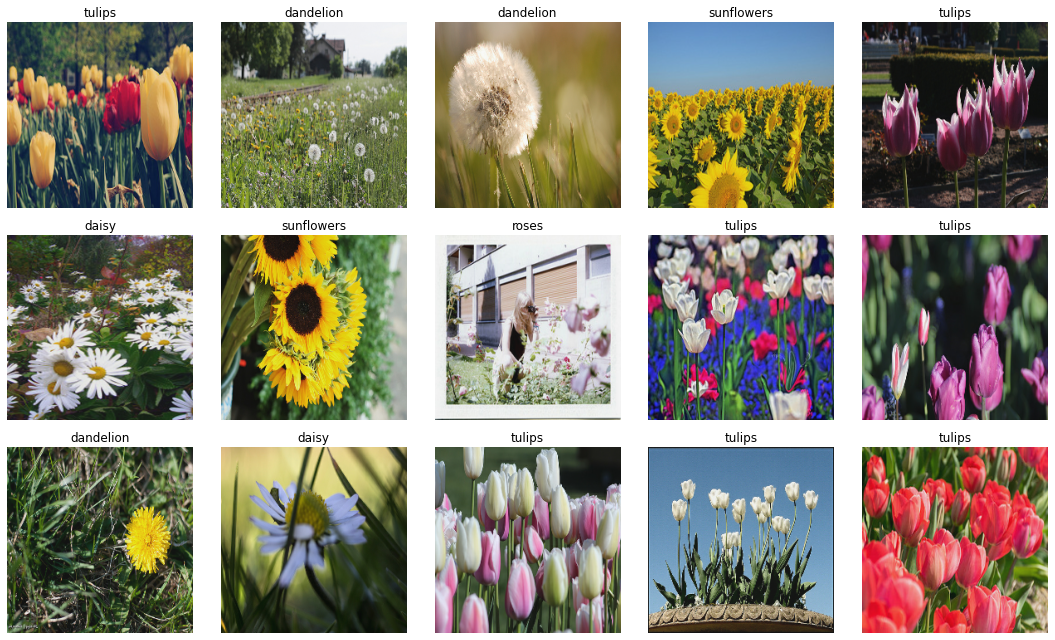

In [ ]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Training HyperParameters

In [ ]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

In [ ]:
lr_schedule = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)
optimizer = tf.keras.optimizers.SGD(lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

## Plot LRSchedule

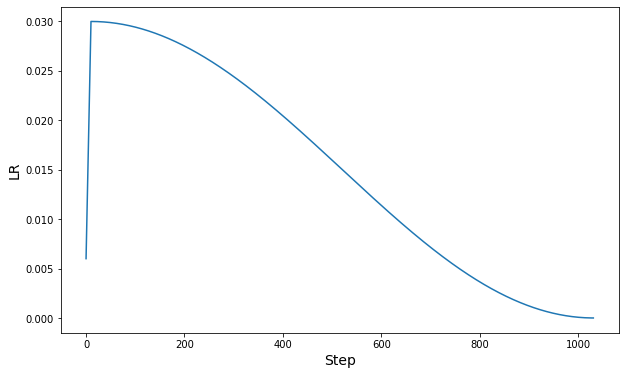

In [ ]:
lrs = [lr_schedule(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

## Building Model

In [ ]:
from gcvit import GCViTTiny

with strategy.scope():    
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')
    
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["accuracy"])

## Save Checkpoint

In [ ]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

## Training

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=[ckpt_callback])

## Training Plot

In [ ]:
import pandas as pd
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

## Predictions

In [ ]:
sample_images, sample_labels = next(iter(val_dataset))
predictions = model.predict(sample_images, batch_size=16).argmax(axis=-1)

## Grad-CAM

In [ ]:
from gcvit.utils import get_gradcam_model, get_gradcam_prediction
from tqdm import tqdm

gradcam_model = get_gradcam_model(model) # make gradcam model

# Generate Grad-CAM heatmaps
heatmaps = []
for i in tqdm(range(15)):
    pred, heatmap = get_gradcam_prediction(sample_images[i].numpy(), gradcam_model, process=False, decode=False)
    heatmaps.append(heatmap)

## Visualize

In [ ]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(heatmaps[i])
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()